# DGA

## To do
- [ ] Filter
  - [ ] Mis-spelling remover
    - [x] Dictionary of domain (Trie)
    - [ ] Fuzzy distance
- [ ] Cleaning Data
  - [ ] Remove Duplicate
- [ ] Pre-processing
  - [x] Length of domain
  - [x] Ratio of vowels in domain
  - [x] Ratio of digits in domain
  - [x] Entropy of domain
  - [ ] N-gram Score
- [ ] Clustering
  - [X] K-Means
  - [ ] DBSCAN


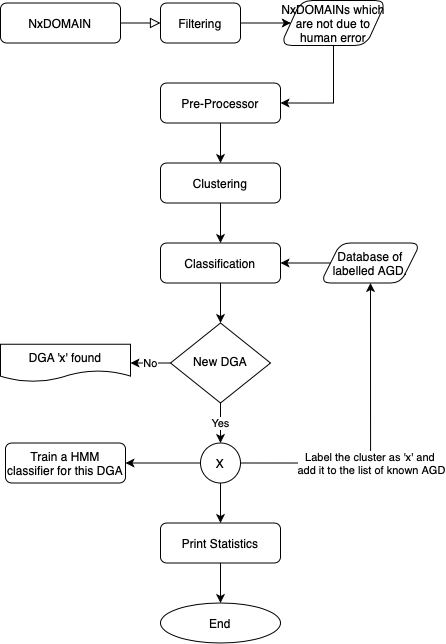





## Filter

In [ ]:
class Node:
    def __init__(self):
        self.prefix = {}
        self.word = False

    def has_prefix(self, character):
        return character in self.prefix

    def add_prefix(self, character):
        _ = Node()
        self.prefix[character] = _
        return _

    def for_prefix(self, character):
        return self.prefix.get(character, 0)

    def remove_prefix(self, character):
        self.prefix.pop(character)

    def word_end(self):
        self.word = True

    def is_word(self):
        return self.word

    def is_leaf(self):
        return len(self.prefix)

    def __str__(self):
        return str(self.prefix)


class Trie:
    def __init__(self):
        self.root = Node()

    def exists(self, word):
        _ = self.root
        for character in word:
            _ = _.for_prefix(character)
            if not _:
                return False
        if _.is_word():
            return True

    def _add_branch(self, node, suffix):
        for character in suffix:
            node = node.add_prefix(character)
        node.word_end()

    def _insert(self, node, suffix):
        if len(suffix) == 1:
            if node.has_prefix(suffix):
                node.for_prefix(suffix).word_end()
                return
            node.add_prefix(suffix).word_end()
            return
        prefix, suffix = suffix[0], suffix[1:]
        if not node.has_prefix(prefix):
            self._add_branch(node.add_prefix(prefix), suffix)
        else:
            self._insert(node.for_prefix(prefix), suffix)

    def insert(self, word):
        return self._insert(self.root, word)

    def _remove_node(self, node, prefix):
        if not node.for_prefix(prefix).is_leaf():
            node.remove_prefix(prefix)

    def _remove(self, node, suffix):
        if len(suffix) == 1:
            if not node.has_prefix(suffix):
                return False
            if node.for_prefix(suffix).is_word():
                self._remove_node(node, suffix)
            return
        prefix, suffix = suffix[0], suffix[1:]
        if not node.has_prefix(prefix):
            return False
        self._remove(node.for_prefix(prefix), suffix)
        self._remove_node(node, prefix)

    def remove(self, word):
        self._remove(self.root, word)


if __name__ == '__main__':
    dict = Trie()
    dict.insert('google')
    dict.insert('apple')
    dict.exists('apple')
    dict.remove('apple')


## Importing Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter as counter
from math import log10
import re
import sciki

## Importing Dataset

In [ ]:
!git clone https://github.com/andrewaeva/DGA.git

Cloning into 'DGA'...
remote: Enumerating objects: 401, done.
remote: Total 401 (delta 0), reused 0 (delta 0), pack-reused 401
Receiving objects: 100% (401/401), 85.54 MiB | 20.39 MiB/s, done.
Resolving deltas: 100% (216/216), done.
Checking out files: 100% (46/46), done.


In [ ]:
# !git clone https://github.com/baderj/domain_generation_algorithms.git

# data.columns = ['Domains']
# data.to_csv('uri.csv',index=False)

# To do : cryptolocker, goz

data = []
for _ in open('/content/DGA/all_dga.txt'):
  data.append(_.strip('\n').split(' ')[0])

benign_dataset = pd.read_csv('/content/uri.csv')
agd_dataset = pd.DataFrame(data,columns=['domains'])

benign_dataset.columns = ['domains']

print('benign_dataset.shape :',benign_dataset.shape)
print('agd_dataset.shape :', agd_dataset.shape)

benign_dataset.shape : (290145, 1)
agd_dataset.shape : (801667, 1)


# Pre-processing

## Functions

In [ ]:
def shanons_entropy(probability_character):
  return probability_character*log10(probability_character)

def entropy_of(obj):
  entropy = 0
  _ = counter(obj)
  for character in _:
    probability_character = _[character]/len(obj)
    entropy += shanons_entropy(probability_character)
  return -entropy

def int_count(obj):
  _ = [c for c in list(obj) if c.isdigit()]
  return len(_)

def ratio_of_digit(obj):
  return int_count(obj)/len(obj.rstrip())

def vowel_count(obj):
  return len(re.findall(r'[aeiou]',obj))

def ratio_of_vowel(obj):
  return vowel_count(obj)/len(obj)

## Processing Dataset

In [ ]:
def modification(dataset, type):
  # Adding the 2_level_domain and top_level_domain to dataset
  _ = dataset['domains'].str.split('.',expand=True)
  dataset['top_level_domain'] = _[1] # there are many domains of form name.xy.xyz.com so take last and first.
  dataset['2_level_domain'] = _[0]

  # Distribution of domains among top level domains
  dataset.top_level_domain.value_counts().rename_axis('top_level_domain').reset_index(name='count')

  # Calculating length of each domain in data set
  _ = dataset['2_level_domain'].apply(len).rename_axis('2_level_domain').reset_index(name='len')
  dataset['len'] = _.len
  print(f'Mean length of {type}: ', dataset.len.mean())

  # Entropy of domains added to dataset
  _ = dataset['2_level_domain'].apply(entropy_of).rename_axis('2_level_domain').reset_index(name='entropy')
  dataset['entropy'] = _.entropy
  print(f'Mean entropy of {type}: ', dataset.entropy.mean())

  _ = dataset['2_level_domain'].apply(ratio_of_vowel).rename_axis('2_level_domain').reset_index(name='ratio')
  dataset['ratio_of_vowels'] = _.ratio
  print(f'Mean vowel ratio of {type}: ', dataset.ratio_of_vowels.mean())

  _ = dataset['2_level_domain'].apply(ratio_of_digit).rename_axis('2_level_domain').reset_index(name='ratio')
  dataset['ratio_of_digits'] = _.ratio
  print(f'Mean digit ratio of {type}: ', dataset.ratio_of_digits.mean())

  print('---------------------------------------------------------')
  return dataset
agd_dataset = modification(agd_dataset,'AGD')
benign_dataset = modification(benign_dataset,'BENIGN')

Mean length of AGD:  16.581047991248237
Mean entropy of AGD:  0.9747301816760419
Mean vowel ratio of AGD:  0.28481004732773085
Mean digit ratio of AGD:  0.041575008037932557
---------------------------------------------------------
Mean length of BENIGN:  9.293518757862449
Mean entropy of BENIGN:  0.8112884828685607
Mean vowel ratio of BENIGN:  0.35870331832416974
Mean digit ratio of BENIGN:  0.024278307193507074
---------------------------------------------------------


# Test

In [ ]:
bi_gram_dict = {}
def n_gram(str, n=3):
  for i in range(len(str) - 2 ):
    bi_gram_dict[str[i:i+n]] = bi_gram_dict.get(str[i:i+n],0) + 1

for index, row in benign_dataset.iterrows():
  n_gram(row[0].split('.')[0])

In [ ]:
bi_gram_dict

33236

In [ ]:
def n_gram_score(str):
  sum = 0
  for i in range(len(str) - 2 ):
    sum+=bi_gram_dict.get(str[i:i+3],0)
  return sum

In [ ]:
  _ = agd_dataset['2_level_domain'].apply(n_gram_score).rename_axis('2_level_domain').reset_index(name='score')
  agd_dataset['score'] = _.score


In [ ]:
x = agd_dataset.iloc[:,3:].values
x

array([[1.50000000e+01, 1.01554193e+00, 1.33333333e-01, 0.00000000e+00,
        4.39000000e+02],
       [1.50000000e+01, 1.00039234e+00, 1.33333333e-01, 0.00000000e+00,
        7.15000000e+02],
       [1.50000000e+01, 1.01554193e+00, 6.66666667e-02, 0.00000000e+00,
        1.85000000e+02],
       ...,
       [1.60000000e+01, 9.78347486e-01, 4.37500000e-01, 0.00000000e+00,
        1.39900000e+03],
       [1.60000000e+01, 9.12313264e-01, 3.75000000e-01, 0.00000000e+00,
        2.13300000e+03],
       [1.60000000e+01, 9.78347486e-01, 3.12500000e-01, 0.00000000e+00,
        1.43500000e+03]])

In [ ]:
temp  = np.asarray(x)

In [ ]:
print(temp)

[[1.50000000e+01 1.01554193e+00 1.33333333e-01 0.00000000e+00
  4.39000000e+02]
 [1.50000000e+01 1.00039234e+00 1.33333333e-01 0.00000000e+00
  7.15000000e+02]
 [1.50000000e+01 1.01554193e+00 6.66666667e-02 0.00000000e+00
  1.85000000e+02]
 ...
 [1.60000000e+01 9.78347486e-01 4.37500000e-01 0.00000000e+00
  1.39900000e+03]
 [1.60000000e+01 9.12313264e-01 3.75000000e-01 0.00000000e+00
  2.13300000e+03]
 [1.60000000e+01 9.78347486e-01 3.12500000e-01 0.00000000e+00
  1.43500000e+03]]


In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
temp_ = imputer.fit(temp[:,:]).transform(temp[:,:])

In [ ]:
temp_

array([[1.50000000e+01, 1.01554193e+00, 1.33333333e-01, 0.00000000e+00,
        4.39000000e+02],
       [1.50000000e+01, 1.00039234e+00, 1.33333333e-01, 0.00000000e+00,
        7.15000000e+02],
       [1.50000000e+01, 1.01554193e+00, 6.66666667e-02, 0.00000000e+00,
        1.85000000e+02],
       ...,
       [1.60000000e+01, 9.78347486e-01, 4.37500000e-01, 0.00000000e+00,
        1.39900000e+03],
       [1.60000000e+01, 9.12313264e-01, 3.75000000e-01, 0.00000000e+00,
        2.13300000e+03],
       [1.60000000e+01, 9.78347486e-01, 3.12500000e-01, 0.00000000e+00,
        1.43500000e+03]])

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(temp,test_size=0.2,random_state=1)

In [ ]:
x_train

(641333, 4)

array([15.        ,  1.00039234,  0.13333333,  0.        ])

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_temp = sc.fit_transform(temp[:,:])

In [ ]:
scaled_temp

array([[-0.21868741,  0.27996245, -0.99994709, -0.36435834, -0.61300597],
       [-0.21868741,  0.17603857, -0.99994709, -0.36435834, -0.59039105],
       [-0.21868741,  0.27996245, -1.44003545, -0.36435834, -0.63381826],
       ...,
       [-0.0803694 ,  0.02481416,  1.00795607, -0.36435834, -0.53434536],
       [-0.0803694 , -0.42817067,  0.59537323, -0.36435834, -0.47420277],
       [-0.0803694 ,  0.02481416,  0.18279039, -0.36435834, -0.53139559]])

Text(0.5, 1.0, 'elbow')

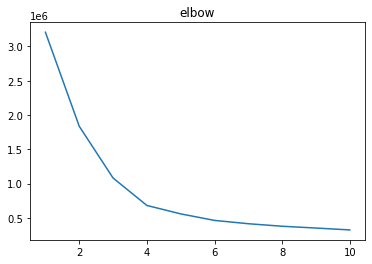

In [ ]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
  kmeans = KMeans(n_clusters = i, init='k-means++', random_state=42)
  kmeans.fit(scaled_temp)
  wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('elbow')

In [ ]:
kmeans = KMeans(n_clusters = 4, init='k-means++', random_state=42)
xy = kmeans.fit_predict(scaled_temp)


In [ ]:
print(xy)

[3 3 3 ... 0 0 3]


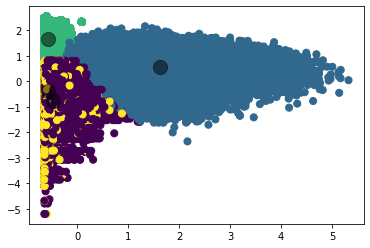

In [ ]:
plt.scatter(scaled_temp[:,-1],scaled_temp[:,1],c=xy, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, -1], centers[:, 1], c='black', s=200, alpha=0.5);

In [ ]:
centers

array([[-0.73991254, -0.76975307,  0.91913978, -0.36435456, -0.48528272],
       [ 1.11875868,  0.57419527,  0.64918128, -0.36200829,  1.62677747],
       [ 1.2862903 ,  1.65143652, -1.04976476,  2.5562326 , -0.5821124 ],
       [-0.66679781, -0.37394903, -0.87939919, -0.36408829, -0.57038877]])

# View

In [ ]:
agd_dataset

,domains,top_level_domain,2_level_domain,len,entropy,ratio_of_vowels,ratio_of_digits,score
0,ofdhiydrrttpblp.com,com,ofdhiydrrttpblp,15,1.015542,0.133333,0.0,439
1,puciftnfkplcbhp.net,net,puciftnfkplcbhp,15,1.000392,0.133333,0.0,715
2,bowjjxxnhkyvygk.biz,biz,bowjjxxnhkyvygk,15,1.015542,0.066667,0.0,185
3,osvwkptpwqyiqen.ru,ru,osvwkptpwqyiqen,15,1.055679,0.200000,0.0,126
4,cpmjpnwdgbxyyql.org,org,cpmjpnwdgbxyyql,15,1.095817,0.000000,0.0,97
...,...,...,...,...,...,...,...,...
801662,yacoouemkmmeaqiu.org,org,yacoouemkmmeaqiu,16,0.964145,0.562500,0.0,2380
801663,yaucyikacowiogem.org,org,yaucyikacowiogem,16,1.015976,0.500000,0.0,2621
801664,iumgkaoasgoyiccy.org,org,iumgkaoasgoyiccy,16,0.978347,0.437500,0.0,1399
801665,aemosuaokkwmqqmq.org,org,aemosuaokkwmqqmq,16,0.912313,0.375000,0.0,2133


In [ ]:
benign_dataset

,domains,top_level_domain,2_level_domain,len,entropy,ratio_of_vowels,ratio_of_digits
0,youtube.com,com,youtube,7,0.759089,0.571429,0.0
1,facebook.com,com,facebook,8,0.827832,0.500000,0.0
2,baidu.com,com,baidu,5,0.698970,0.600000,0.0
3,wikipedia.org,org,wikipedia,9,0.795202,0.555556,0.0
4,yahoo.com,com,yahoo,5,0.578558,0.600000,0.0
...,...,...,...,...,...,...,...
290140,kojakhoobe.com,com,kojakhoobe,10,0.796658,0.500000,0.0
290141,watkykjy.co.za,co,watkykjy,8,0.752575,0.125000,0.0
290142,gov.lt,lt,gov,3,0.477121,0.333333,0.0
290143,ymcaquebec.org,org,ymcaquebec,10,0.879588,0.400000,0.0


In [ ]:
#!pip install pyenchant

     |████████████████████████████████| 61kB 1.9MB/s 


In [ ]:
# !pip install googletrans

# 10.128.68.59

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15777 sha256=903e866a30284ae39bba376d0522c929849eb366af07e9ea3f3251472b4c3f7e
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans
